In [1]:
# Colab: run this cell first
!pip install -q transformers datasets accelerate torchmetrics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.2/983.2 kB 23.2 MB/s eta 0:00:00


In [2]:
# Imports
import os
import math
import time
import json
import random
from pathlib import Path
from collections import defaultdict

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader

from transformers import AutoTokenizer
from datasets import load_dataset

from tqdm.auto import tqdm


In [3]:
torch.cuda.is_available()

True

In [4]:
# CONFIG - tweak these
CONFIG = {
    "model_size": "small",   # "small" or "medium"
    "d_model_small": 256,
    "nhead_small": 4,
    "num_layers_small": 4,
    "ff_dim_small": 1024,
    "d_model_medium": 512,
    "nhead_medium": 8,
    "num_layers_medium": 8,
    "ff_dim_medium": 2048,

    "max_len": 256,
    "tokenizer_name": "bert-base-uncased",  # tokenizer only
    "num_epochs": 6,
    "batch_size": 32,   # default, you will sweep this externally
    "learning_rate": 1e-4,
    "weight_decay": 0.01,
    "warmup_steps": 500,
    "seed": 42,
    "device": "cuda" if torch.cuda.is_available() else "cpu",
    "log_dir": "logs_imdb_transformer",
    "save_checkpoints": True,
    "checkpoints_dir": "checkpoints_imdb_transformer",
    "capture_checkpoints": [1, 3, 6],  # epochs to capture gradient distributions (1, mid, final)
}
os.makedirs(CONFIG["log_dir"], exist_ok=True)
os.makedirs(CONFIG["checkpoints_dir"], exist_ok=True)

def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

set_seed(CONFIG["seed"])
device = torch.device(CONFIG["device"])
print("Device:", device)


Device: cuda


In [5]:
# Load IMDB dataset and tokenizer
tokenizer = AutoTokenizer.from_pretrained(CONFIG["tokenizer_name"])

def tokenize_batch(batch):
    return tokenizer(batch["text"], padding="max_length", truncation=True, max_length=CONFIG["max_len"])

print("Downloading dataset (this may take a minute)...")
ds = load_dataset("imdb")
# keep train and test; create validation split from train
ds = ds["train"].train_test_split(test_size=0.1, seed=CONFIG["seed"])
train_ds = ds["train"]
val_ds = ds["test"]
test_ds = load_dataset("imdb", split="test")  # official test 25k

# tokenize and format
train_ds = train_ds.map(tokenize_batch, batched=True, remove_columns=["text"])
val_ds = val_ds.map(tokenize_batch, batched=True, remove_columns=["text"])
test_ds = test_ds.map(tokenize_batch, batched=True, remove_columns=["text"])

columns = ["input_ids", "attention_mask", "label"]
train_ds.set_format(type="torch", columns=columns)
val_ds.set_format(type="torch", columns=columns)
test_ds.set_format(type="torch", columns=columns)

def make_dataloader(ds_split, batch_size, shuffle=False):
    return DataLoader(ds_split, batch_size=batch_size, shuffle=shuffle)


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

plain_text/train-00000-of-00001.parquet:   0%|          | 0.00/21.0M [00:00<?, ?B/s]

plain_text/test-00000-of-00001.parquet:   0%|          | 0.00/20.5M [00:00<?, ?B/s]

plain_text/unsupervised-00000-of-00001.p(…):   0%|          | 0.00/42.0M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating unsupervised split:   0%|          | 0/50000 [00:00<?, ? examples/s]

Map:   0%|          | 0/22500 [00:00<?, ? examples/s]

Map:   0%|          | 0/2500 [00:00<?, ? examples/s]

Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

In [6]:
# Transformer encoder block with configurable normalization
class TransformerEncoderLayerCustom(nn.Module):
    def __init__(self, d_model, nhead, dim_feedforward, norm_type="layernorm", dropout=0.1):
        super().__init__()
        self.self_attn = nn.MultiheadAttention(d_model, nhead, dropout=dropout, batch_first=True)
        self.linear1 = nn.Linear(d_model, dim_feedforward)
        self.linear2 = nn.Linear(dim_feedforward, d_model)
        self.dropout = nn.Dropout(dropout)

        # Normalization modules for the two sublayers
        self.norm_type = norm_type
        if norm_type == "layernorm":
            self.norm1 = nn.LayerNorm(d_model)
            self.norm2 = nn.LayerNorm(d_model)
        elif norm_type == "batchnorm":
            # Use BatchNorm1d over features. We'll apply by reshaping (B*S, D)
            self.norm1 = nn.BatchNorm1d(d_model, affine=True, eps=1e-5, momentum=0.1)
            self.norm2 = nn.BatchNorm1d(d_model, affine=True, eps=1e-5, momentum=0.1)
        else:
            raise ValueError("norm_type must be 'layernorm' or 'batchnorm'")

    def _apply_norm(self, x, norm_module):
        # x: (batch, seq_len, d_model)
        if self.norm_type == "layernorm":
            return norm_module(x)
        else:
            B, S, D = x.shape
            x_flat = x.contiguous().view(B*S, D)
            # BatchNorm1d expects (N, C) where C = D
            x_norm = norm_module(x_flat)
            return x_norm.view(B, S, D)

    def forward(self, src, src_mask=None, src_key_padding_mask=None):
        # Self-attention sublayer
        attn_out, _ = self.self_attn(src, src, src, attn_mask=src_mask, key_padding_mask=src_key_padding_mask)
        src2 = self._apply_norm(src + self.dropout(attn_out), self.norm1)

        # Feed-forward sublayer
        ff = self.linear2(self.dropout(F.relu(self.linear1(src2))))
        src3 = self._apply_norm(src2 + self.dropout(ff), self.norm2)
        return src3

class TransformerEncoderCustom(nn.Module):
    def __init__(self, d_model, nhead, num_layers, dim_feedforward, vocab_size, max_len,
                 norm_type="layernorm", dropout=0.1):
        super().__init__()
        self.token_embedding = nn.Embedding(vocab_size, d_model, padding_idx=tokenizer.pad_token_id)
        self.position_embedding = nn.Embedding(max_len, d_model)
        self.layers = nn.ModuleList([TransformerEncoderLayerCustom(
            d_model, nhead, dim_feedforward, norm_type=norm_type, dropout=dropout
        ) for _ in range(num_layers)])
        self.dropout = nn.Dropout(dropout)
        self.d_model = d_model
        self.max_len = max_len

        # final classifier head
        self.classifier = nn.Linear(d_model, 2)

    def forward(self, input_ids, attention_mask=None):
        B, S = input_ids.shape
        positions = torch.arange(0, S, device=input_ids.device).unsqueeze(0).expand(B, S)
        x = self.token_embedding(input_ids) + self.position_embedding(positions)
        x = self.dropout(x)

        # Create key_padding_mask expected by MultiheadAttention: bool mask with True at padding positions
        key_padding_mask = (input_ids == tokenizer.pad_token_id) if attention_mask is None else (attention_mask == 0)

        for layer in self.layers:
            x = layer(x, src_key_padding_mask=key_padding_mask)

        # Pooling: mean over non-padded tokens
        if attention_mask is None:
            pooled = x.mean(dim=1)
        else:
            mask = attention_mask.unsqueeze(-1)  # (B, S, 1)
            pooled = (x * mask).sum(dim=1) / (mask.sum(dim=1) + 1e-9)

        logits = self.classifier(pooled)
        return logits

In [7]:
import torch.nn as nn

def compute_global_grad_norm(model):
    total = 0.0
    for p in model.parameters():
        if p.grad is None:
            continue
        total += (p.grad.detach()**2).sum().item()
    return math.sqrt(total)

def compute_layerwise_grad_norms(model):
    layer_norms = {}
    for name, p in model.named_parameters():
        if p.grad is None:
            continue
        layer = name.split('.')[0]
        if layer not in layer_norms:
            layer_norms[layer] = 0.0
        layer_norms[layer] += (p.grad.detach()**2).sum().item()
    # sqrt per layer
    for k in list(layer_norms.keys()):
        layer_norms[k] = math.sqrt(layer_norms[k])
    return layer_norms

# Activation capture hooks (capture outputs of some modules)
def register_activation_hooks(model, capture_names):
    activations = {}
    hooks = []
    for name, module in model.named_modules():
        if any(name.endswith(cn) for cn in capture_names):
            def make_hook(n):
                def hook(mod, inp, out):
                    # MultiheadAttention returns a tuple (attn_output, attn_output_weights)
                    # We only care about the attn_output
                    if isinstance(out, tuple):
                        activations[n] = out[0].detach().cpu()
                    else:
                        activations[n] = out.detach().cpu()
                return hook
            hooks.append(module.register_forward_hook(make_hook(name)))
    return activations, hooks

# checkbox: which modules to capture -> pick first and last FFN and attention
def default_capture_names(model):
    names = []
    for name, module in model.named_modules():
        if isinstance(module, TransformerEncoderLayerCustom):
            names.append(name + ".self_attn")
            names.append(name + ".linear1")
            break
    # also capture last
    for name, module in reversed(list(model.named_modules())):
        if isinstance(module, TransformerEncoderLayerCustom):
            names.append(name + ".self_attn")
            names.append(name + ".linear1")
            break
    return names

In [8]:
from torch.optim import AdamW
from torch.utils.tensorboard import SummaryWriter  # optional

def train_and_evaluate(norm_type="layernorm", model_size="small", batch_size=32, lr=1e-4,
                       num_epochs=6, seed=42, capture_checkpoints=[1,3,6], device=device):
    set_seed(seed)
    logdir = Path(CONFIG["log_dir"]) / f"{norm_type}_bs{batch_size}_seed{seed}"
    logdir.mkdir(parents=True, exist_ok=True)

    # model config
    if model_size == "small":
        d_model = CONFIG["d_model_small"]
        nhead = CONFIG["nhead_small"]
        num_layers = CONFIG["num_layers_small"]
        ff_dim = CONFIG["ff_dim_small"]
    else:
        d_model = CONFIG["d_model_medium"]
        nhead = CONFIG["nhead_medium"]
        num_layers = CONFIG["num_layers_medium"]
        ff_dim = CONFIG["ff_dim_medium"]

    vocab_size = tokenizer.vocab_size
    model = TransformerEncoderCustom(d_model=d_model, nhead=nhead, num_layers=num_layers,
                                     dim_feedforward=ff_dim, vocab_size=vocab_size,
                                     max_len=CONFIG["max_len"], norm_type=norm_type).to(device)

    optimizer = AdamW(model.parameters(), lr=lr, weight_decay=CONFIG["weight_decay"])
    total_steps = math.ceil(len(train_ds) / batch_size) * num_epochs
    scheduler = None  # you can implement a warmup scheduler if desired

    train_loader = make_dataloader(train_ds, batch_size=batch_size, shuffle=True)
    val_loader = make_dataloader(val_ds, batch_size=batch_size, shuffle=False)
    test_loader = make_dataloader(test_ds, batch_size=batch_size, shuffle=False)

    history = {
        "train_loss": [], "train_acc": [], "val_loss": [], "val_acc": [],
        "global_grad_norms": [],  # sampled per step
        "layer_grad_snapshots": {},  # epoch -> layer-> list of grads (for violin)
        "bn_running_stats": {},  # if BN: epoch->mean/var arrays (optionally)
    }

    # For activation capture: register a couple useful modules
    capture_names = default_capture_names(model)
    activations, hooks = register_activation_hooks(model, capture_names)

    step = 0
    for epoch in range(1, num_epochs+1):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        pbar = tqdm(train_loader, desc=f"Train epoch {epoch}/{num_epochs}")
        for batch in pbar:
            optimizer.zero_grad()
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["label"].to(device)

            logits = model(input_ids, attention_mask=attention_mask)
            loss = F.cross_entropy(logits, labels)
            loss.backward()

            # compute and log global grad norm occasionally
            gnorm = compute_global_grad_norm(model)
            history["global_grad_norms"].append((step, gnorm))
            step += 1

            optimizer.step()

            preds = torch.argmax(logits, dim=1)
            correct += (preds == labels).sum().item()
            total += labels.shape[0]
            running_loss += loss.item() * labels.shape[0]
            pbar.set_postfix({"loss": loss.item(), "step": step})

        epoch_train_loss = running_loss / total
        epoch_train_acc = correct / total
        history["train_loss"].append(epoch_train_loss)
        history["train_acc"].append(epoch_train_acc)

        # validation
        model.eval()
        vloss = 0.0
        vcorrect = 0
        vtotal = 0
        with torch.no_grad():
            for batch in val_loader:
                input_ids = batch["input_ids"].to(device)
                attention_mask = batch["attention_mask"].to(device)
                labels = batch["label"].to(device)
                logits = model(input_ids, attention_mask=attention_mask)
                loss = F.cross_entropy(logits, labels)
                vloss += loss.item() * labels.shape[0]
                preds = torch.argmax(logits, dim=1)
                vcorrect += (preds == labels).sum().item()
                vtotal += labels.shape[0]
        epoch_val_loss = vloss / vtotal
        epoch_val_acc = vcorrect / vtotal
        history["val_loss"].append(epoch_val_loss)
        history["val_acc"].append(epoch_val_acc)

        print(f"Epoch {epoch}: train_loss={epoch_train_loss:.4f}, train_acc={epoch_train_acc:.4f}, val_loss={epoch_val_loss:.4f}, val_acc={epoch_val_acc:.4f}")

        # capture gradient distributions at selected epochs
        if epoch in capture_checkpoints:
            # run one small pass to collect gradients per parameter (use one minibatch)
            # We'll compute gradients for a single batch to inspect distribution
            some_batch = next(iter(train_loader))
            optimizer.zero_grad()
            input_ids = some_batch["input_ids"].to(device)
            attention_mask = some_batch["attention_mask"].to(device)
            labels = some_batch["label"].to(device)
            logits = model(input_ids, attention_mask=attention_mask)
            loss = F.cross_entropy(logits, labels)
            loss.backward()

            # collect per-layer gradients (flattened) for violin plot
            layerwise = defaultdict(list)
            for name, p in model.named_parameters():
                if p.grad is None:
                    continue
                layer = name.split('.')[0]
                flat = p.grad.detach().cpu().view(-1).numpy()
                layerwise[layer].append(flat)
            # concatenate per-layer arrays
            layerwise_concat = {k: np.concatenate(v) for k, v in layerwise.items()}
            history["layer_grad_snapshots"][epoch] = layerwise_concat

        # collect BN running stats if applicable
        if norm_type == "batchnorm":
            # average running_mean and running_var across all BatchNorm1d modules
            means = []
            vars_ = []
            for module in model.modules():
                if isinstance(module, nn.BatchNorm1d):
                    means.append(module.running_mean.detach().cpu().numpy().copy())
                    vars_.append(module.running_var.detach().cpu().numpy().copy())
            if len(means) > 0:
                # average across modules (shape: num_modules x D); compute mean across modules -> (D,)
                history["bn_running_stats"][epoch] = {
                    "mean": np.mean(np.stack(means), axis=0),
                    "var": np.mean(np.stack(vars_), axis=0)
                }

        # save checkpoint optionally
        if CONFIG["save_checkpoints"]:
            ckpt_path = Path(CONFIG["checkpoints_dir"]) / f"{norm_type}_bs{batch_size}_seed{seed}_epoch{epoch}.pt"
            torch.save({
                "model_state": model.state_dict(),
                "optimizer_state": optimizer.state_dict(),
                "epoch": epoch,
                "config": {"norm_type": norm_type, "batch_size": batch_size, "seed": seed}
            }, ckpt_path)

    # final test eval
    model.eval()
    tcorrect = 0
    ttotal = 0
    with torch.no_grad():
        for batch in test_loader:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["label"].to(device)
            logits = model(input_ids, attention_mask=attention_mask)
            preds = torch.argmax(logits, dim=1)
            tcorrect += (preds == labels).sum().item()
            ttotal += labels.shape[0]
    test_acc = tcorrect / ttotal
    print("Test accuracy:", test_acc)

    # cleanup hooks
    for h in hooks:
        h.remove()

    return history, test_acc

In [ ]:
# Quick runs - small model, batch_size 32
hist_ln, test_acc_ln = train_and_evaluate(norm_type="layernorm", model_size="small",
                                          batch_size=32, lr=1e-4, num_epochs=CONFIG["num_epochs"],
                                          seed=CONFIG["seed"], capture_checkpoints=CONFIG["capture_checkpoints"])
hist_bn, test_acc_bn = train_and_evaluate(norm_type="batchnorm", model_size="small",
                                          batch_size=32, lr=1e-4, num_epochs=CONFIG["num_epochs"],
                                          seed=CONFIG["seed"], capture_checkpoints=CONFIG["capture_checkpoints"])

# Save histories
with open("history_ln.json", "w") as f:
    json.dump(hist_ln, f, default=lambda o: (o.tolist() if isinstance(o, np.ndarray) else o))
with open("history_bn.json", "w") as f:
    json.dump(hist_bn, f, default=lambda o: (o.tolist() if isinstance(o, np.ndarray) else o))
print("Done runs. LN test acc:", test_acc_ln, "BN test acc:", test_acc_bn)

Train epoch 1/6:   0%|          | 0/704 [00:00<?, ?it/s]

Epoch 1: train_loss=0.5917, train_acc=0.6767, val_loss=0.4918, val_acc=0.7576


Train epoch 2/6:   0%|          | 0/704 [00:00<?, ?it/s]

Epoch 2: train_loss=0.4695, train_acc=0.7763, val_loss=0.4435, val_acc=0.7912


Train epoch 3/6:   0%|          | 0/704 [00:00<?, ?it/s]

Epoch 3: train_loss=0.4187, train_acc=0.8069, val_loss=0.4595, val_acc=0.7912


Train epoch 4/6:   0%|          | 0/704 [00:00<?, ?it/s]

Epoch 4: train_loss=0.3753, train_acc=0.8316, val_loss=0.3983, val_acc=0.8296


Train epoch 5/6:   0%|          | 0/704 [00:00<?, ?it/s]

Epoch 5: train_loss=0.3461, train_acc=0.8484, val_loss=0.3951, val_acc=0.8300


Train epoch 6/6:   0%|          | 0/704 [00:00<?, ?it/s]

Epoch 6: train_loss=0.3134, train_acc=0.8651, val_loss=0.3793, val_acc=0.8380
Test accuracy: 0.82048


Train epoch 1/6:   0%|          | 0/704 [00:00<?, ?it/s]

Epoch 1: train_loss=0.5619, train_acc=0.7072, val_loss=0.4951, val_acc=0.7628


Train epoch 2/6:   0%|          | 0/704 [00:00<?, ?it/s]

Epoch 2: train_loss=0.4565, train_acc=0.7814, val_loss=0.4210, val_acc=0.8032


Train epoch 3/6:   0%|          | 0/704 [00:00<?, ?it/s]

Epoch 3: train_loss=0.3961, train_acc=0.8195, val_loss=0.3864, val_acc=0.8236


Train epoch 4/6:   0%|          | 0/704 [00:00<?, ?it/s]

Epoch 4: train_loss=0.3477, train_acc=0.8437, val_loss=0.4223, val_acc=0.8128


Train epoch 5/6:   0%|          | 0/704 [00:00<?, ?it/s]

Epoch 5: train_loss=0.3001, train_acc=0.8720, val_loss=0.4767, val_acc=0.7864


Train epoch 6/6:   0%|          | 0/704 [00:00<?, ?it/s]

Epoch 6: train_loss=0.2542, train_acc=0.8922, val_loss=0.5187, val_acc=0.7800
Test accuracy: 0.77836
Done runs. LN test acc: 0.82048 BN test acc: 0.77836


In [9]:
# PLOTTING FUNCTIONS
def plot_loss_and_accuracy(history, norm_type, save_prefix="plot"):
    epochs = np.arange(1, len(history["train_loss"]) + 1)
    fig, axes = plt.subplots(1, 2, figsize=(10, 4))

    # Loss plot
    axes[0].plot(epochs, history["train_loss"], label=f"Train Loss {norm_type}")
    axes[0].plot(epochs, history["val_loss"], linestyle="--", label=f"Val Loss {norm_type}")
    axes[0].set_xlabel("Epoch")
    axes[0].set_ylabel("Loss")
    axes[0].set_title(f"Training & Validation Loss ({norm_type})")
    axes[0].legend()

    # Accuracy plot
    axes[1].plot(epochs, history["train_acc"], label=f"Train Acc {norm_type}")
    axes[1].plot(epochs, history["val_acc"], linestyle="--", label=f"Val Acc {norm_type}")
    axes[1].set_xlabel("Epoch")
    axes[1].set_ylabel("Accuracy")
    axes[1].set_title(f"Training & Validation Accuracy ({norm_type})")
    axes[1].legend()

    plt.tight_layout()
    plt.savefig(f"{save_prefix}_{norm_type.lower()}_loss_acc.png", dpi=200)
    plt.show()

def plot_combined_loss(hist_bn, hist_ln, save_prefix="plot"):
    epochs = np.arange(1, len(hist_bn["train_loss"]) + 1)
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))

    # BatchNorm Loss
    axes[0].plot(epochs, hist_bn["train_loss"], label="Train Loss BatchNorm")
    axes[0].plot(epochs, hist_bn["val_loss"], linestyle="--", label="Val Loss BatchNorm")
    axes[0].set_xlabel("Epoch")
    axes[0].set_ylabel("Loss")
    axes[0].set_title("Training & Validation Loss (BatchNorm)")
    axes[0].legend()

    # LayerNorm Loss
    axes[1].plot(epochs, hist_ln["train_loss"], label="Train Loss LayerNorm")
    axes[1].plot(epochs, hist_ln["val_loss"], linestyle="--", label="Val Loss LayerNorm")
    axes[1].set_xlabel("Epoch")
    axes[1].set_ylabel("Loss")
    axes[1].set_title("Training & Validation Loss (LayerNorm)")
    axes[1].legend()

    plt.tight_layout()
    plt.savefig(f"{save_prefix}_combined_loss.png", dpi=200)
    plt.show()

def plot_combined_accuracy(hist_bn, hist_ln, save_prefix="plot"):
    epochs = np.arange(1, len(hist_bn["train_acc"]) + 1)
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))

    # BatchNorm Accuracy
    axes[0].plot(epochs, hist_bn["train_acc"], label="Train Acc BatchNorm")
    axes[0].plot(epochs, hist_bn["val_acc"], linestyle="--", label="Val Acc BatchNorm")
    axes[0].set_xlabel("Epoch")
    axes[0].set_ylabel("Accuracy")
    axes[0].set_title("Training & Validation Accuracy (BatchNorm)")
    axes[0].legend()

    # LayerNorm Accuracy
    axes[1].plot(epochs, hist_ln["train_acc"], label="Train Acc LayerNorm")
    axes[1].plot(epochs, hist_ln["val_acc"], linestyle="--", label="Val Acc LayerNorm")
    axes[1].set_xlabel("Epoch")
    axes[1].set_ylabel("Accuracy")
    axes[1].set_title("Training & Validation Accuracy (LayerNorm)")
    axes[1].legend()

    plt.tight_layout()
    plt.savefig(f"{save_prefix}_combined_accuracy.png", dpi=200)
    plt.show()

def plot_sensitivity_batch_size(results_by_batch, save_name="sensitivity_batch.png"):
    # results_by_batch: dict {batch_size: {"layernorm": test_acc, "batchnorm": test_acc}}
    batches = sorted(results_by_batch.keys())
    ln_vals = [results_by_batch[b]["layernorm"] for b in batches]
    bn_vals = [results_by_batch[b]["batchnorm"] for b in batches]

    plt.figure()
    plt.plot(batches, ln_vals, marker='o', label="LayerNorm")
    plt.plot(batches, bn_vals, marker='o', label="BatchNorm")
    plt.xlabel("Batch size")
    plt.ylabel("Final Validation Accuracy")
    plt.title("Sensitivity to Batch Size")
    plt.xscale("log", base=2)
    plt.xticks(batches, batches)
    plt.legend()
    plt.grid(True, which='both', ls='--', alpha=0.3)
    plt.savefig(save_name, dpi=200)
    plt.show()

def plot_global_grad_norm(history, norm_type, save_name="global_grad_norm.png"):
    # history["global_grad_norms"] is a list of (step, value) appended per step
    steps, norms = zip(*history["global_grad_norms"])
    plt.figure()
    plt.semilogy(steps, norms, label=f"Global Grad Norm {norm_type}")
    plt.xlabel("Training Step")
    plt.ylabel("Global L2 Gradient Norm (log scale)")
    plt.title(f"Global Gradient Norm vs Training Step ({norm_type})")
    plt.legend()
    plt.grid(True, which='both', ls='--', alpha=0.3)
    plt.savefig(f"{norm_type.lower()}_{save_name}", dpi=200)
    plt.show()

def plot_layer_grad_violin(hist_snapshots_ln, hist_snapshots_bn, save_name="layer_grad_violin.png"):
    # hist_snapshots: dict epoch -> {layer_name: np.array(grads)}
    # We'll plot for epochs that both have in common
    epochs = sorted(set(hist_snapshots_ln.keys()) & set(hist_snapshots_bn.keys()))
    for epoch in epochs:
        data_ln = hist_snapshots_ln[epoch]
        data_bn = hist_snapshots_bn[epoch]
        # find common layers
        layers = sorted(set(data_ln.keys()) & set(data_bn.keys()))
        # prepare data lists for violinplot: for each layer, two violins (LN, BN)
        fig, ax = plt.subplots(figsize=(12, 6))
        positions = []
        violin_data = []
        pos = 1
        ticks = []
        for layer in layers:
            violin_data.append(data_ln[layer])  # LN
            positions.append(pos)
            pos += 1
            violin_data.append(data_bn[layer])  # BN
            positions.append(pos)
            pos += 1
            ticks.append((pos - 1.5))
        parts = ax.violinplot(violin_data, positions=positions, showextrema=False)
        # simple labeling: pairs
        ax.set_xticks(ticks)
        ax.set_xticklabels(layers, rotation=45, ha="right")
        ax.set_title(f"Layer-wise Gradient Distribution (Epoch {epoch}) - LN (left) vs BN (right) per layer")
        ax.set_ylabel("Gradient values (flattened)")
        ax.set_xlabel("Layer")
        plt.tight_layout()
        plt.savefig(f"{save_name}_epoch{epoch}.png", dpi=200)
        plt.show()

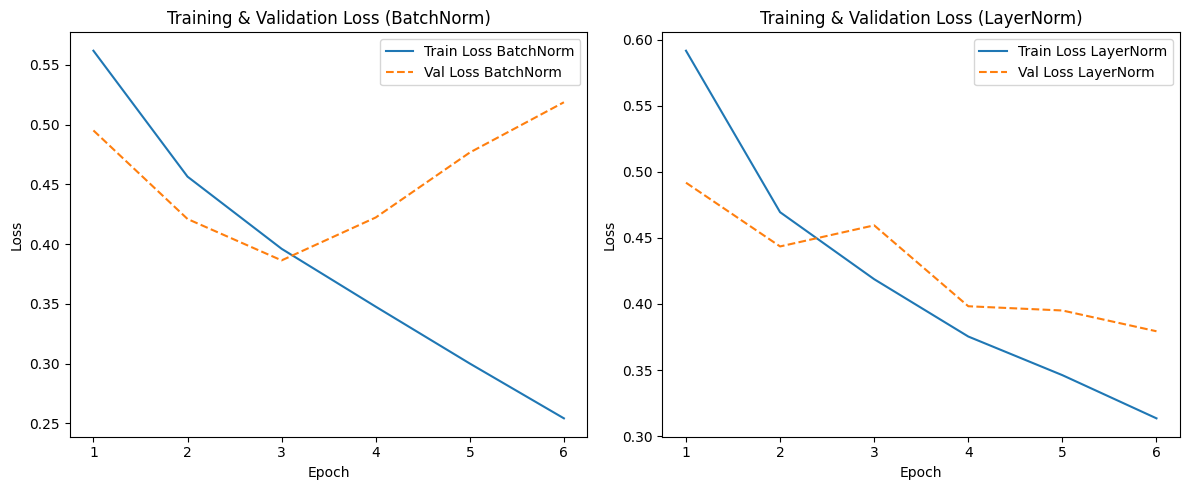

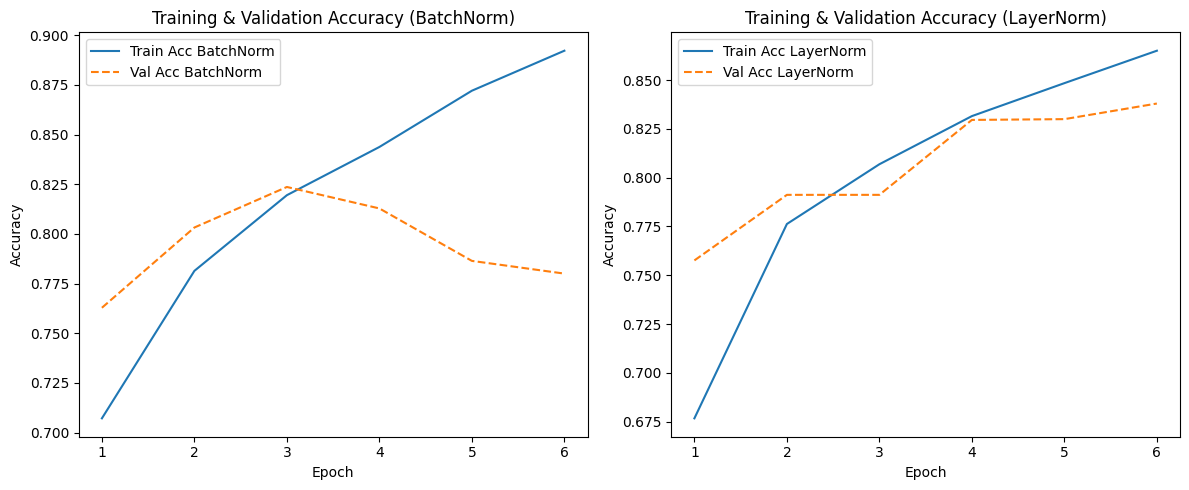

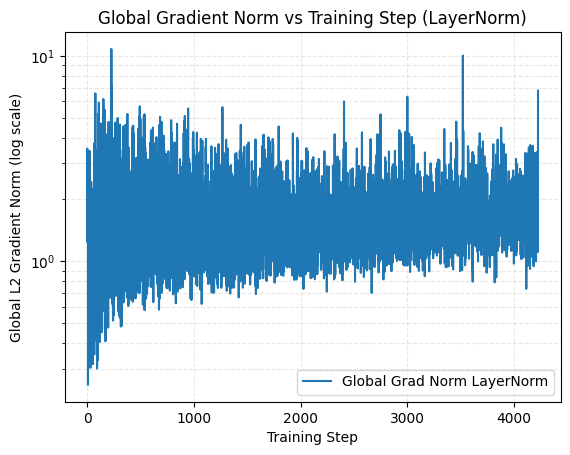

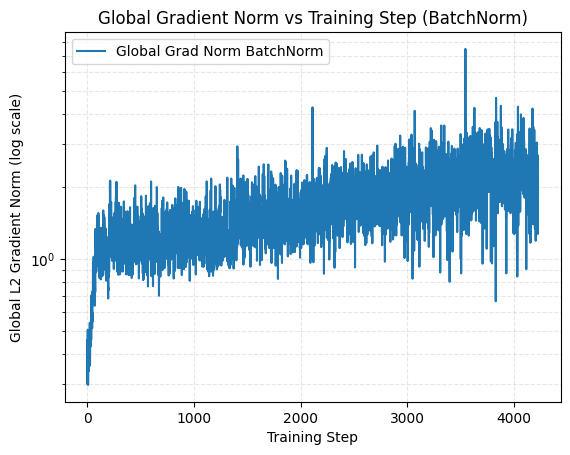

In [ ]:
plot_combined_loss(hist_bn, hist_ln)
plot_combined_accuracy(hist_bn, hist_ln)
plot_global_grad_norm(hist_ln, "LayerNorm")
plot_global_grad_norm(hist_bn, "BatchNorm")

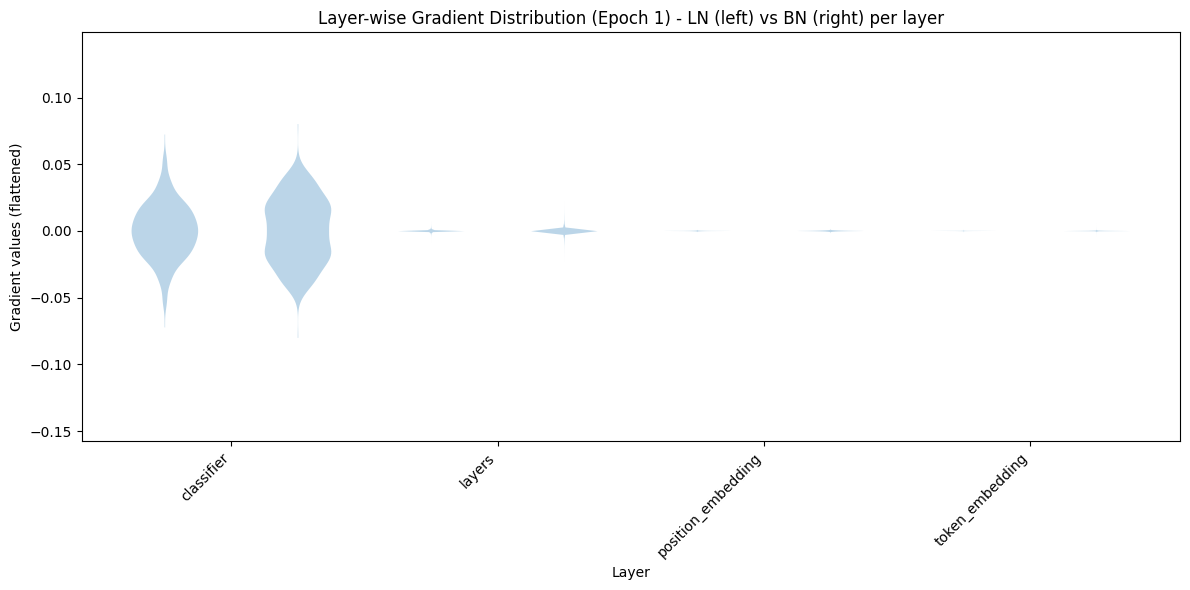

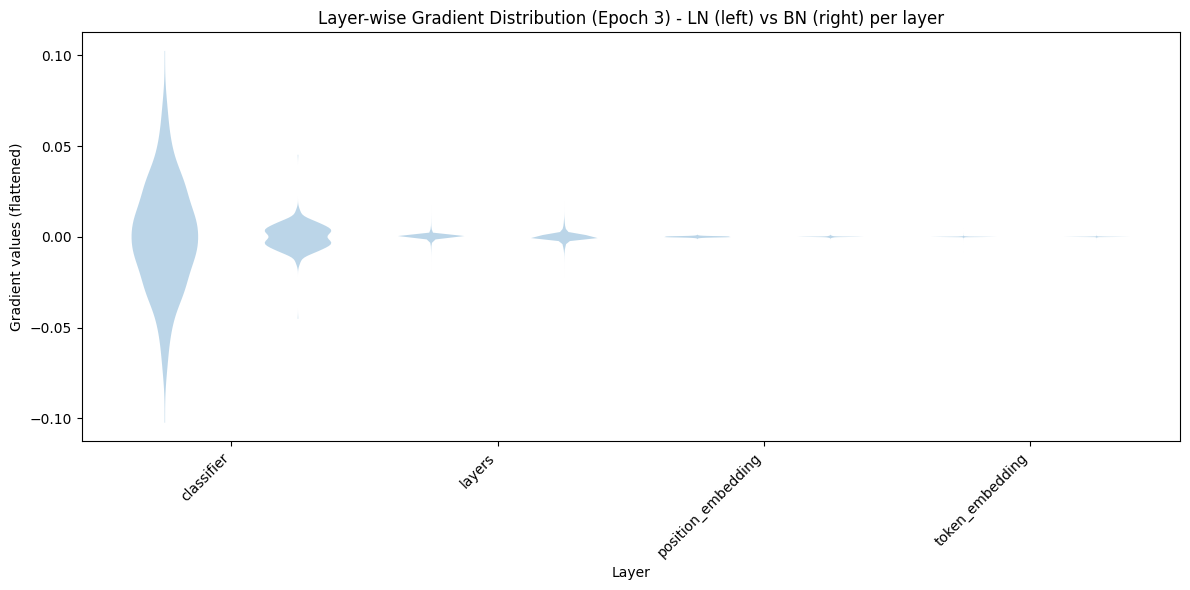

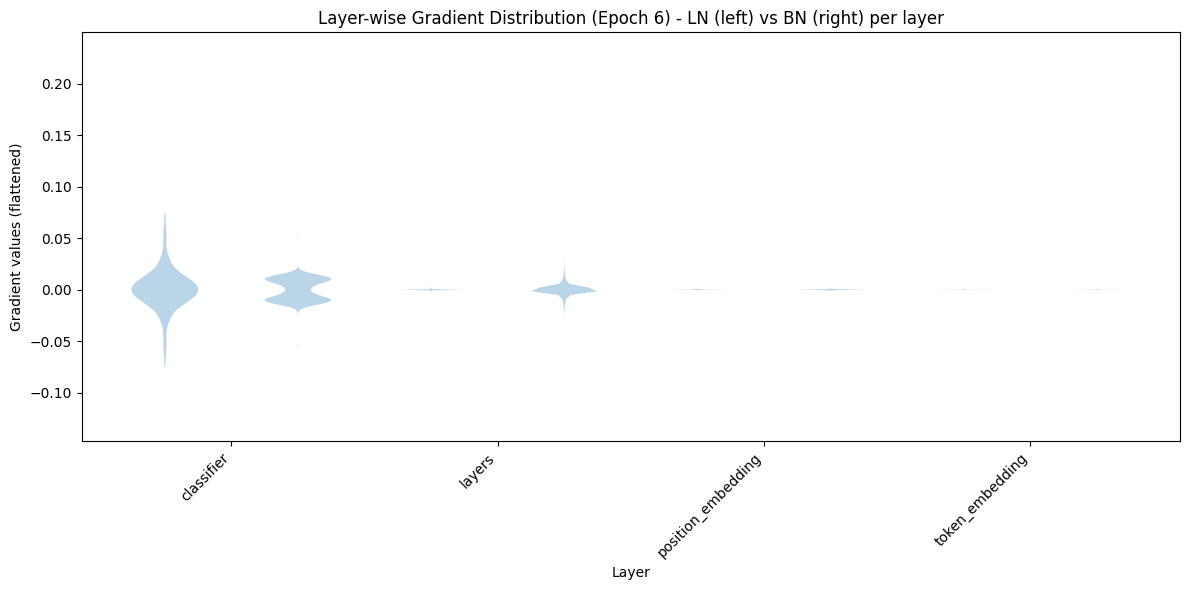

In [ ]:
plot_layer_grad_violin(hist_ln["layer_grad_snapshots"], hist_bn["layer_grad_snapshots"])

Running LN bs= 8


Train epoch 1/6:   0%|          | 0/2813 [00:00<?, ?it/s]

Epoch 1: train_loss=0.5518, train_acc=0.7048, val_loss=0.4380, val_acc=0.7944


Train epoch 2/6:   0%|          | 0/2813 [00:00<?, ?it/s]

Epoch 2: train_loss=0.4249, train_acc=0.8020, val_loss=0.4083, val_acc=0.8192


Train epoch 3/6:   0%|          | 0/2813 [00:00<?, ?it/s]

Epoch 3: train_loss=0.3677, train_acc=0.8373, val_loss=0.3929, val_acc=0.8256


Train epoch 4/6:   0%|          | 0/2813 [00:00<?, ?it/s]

Epoch 4: train_loss=0.3250, train_acc=0.8609, val_loss=0.3879, val_acc=0.8300


Train epoch 5/6:   0%|          | 0/2813 [00:00<?, ?it/s]

Epoch 5: train_loss=0.2967, train_acc=0.8749, val_loss=0.3860, val_acc=0.8360


Train epoch 6/6:   0%|          | 0/2813 [00:00<?, ?it/s]

Epoch 6: train_loss=0.2736, train_acc=0.8854, val_loss=0.3800, val_acc=0.8424
Test accuracy: 0.82748
Running BN bs= 8


Train epoch 1/6:   0%|          | 0/2813 [00:00<?, ?it/s]

Epoch 1: train_loss=0.5503, train_acc=0.7137, val_loss=0.4475, val_acc=0.8108


Train epoch 2/6:   0%|          | 0/2813 [00:00<?, ?it/s]

Epoch 2: train_loss=0.4564, train_acc=0.7821, val_loss=0.4067, val_acc=0.8124


Train epoch 3/6:   0%|          | 0/2813 [00:00<?, ?it/s]

Epoch 3: train_loss=0.4008, train_acc=0.8171, val_loss=0.3902, val_acc=0.8188


Train epoch 4/6:   0%|          | 0/2813 [00:00<?, ?it/s]

Epoch 4: train_loss=0.3475, train_acc=0.8481, val_loss=0.3805, val_acc=0.8340


Train epoch 5/6:   0%|          | 0/2813 [00:00<?, ?it/s]

Epoch 5: train_loss=0.3034, train_acc=0.8725, val_loss=0.3909, val_acc=0.8316


Train epoch 6/6:   0%|          | 0/2813 [00:00<?, ?it/s]

Epoch 6: train_loss=0.2642, train_acc=0.8872, val_loss=0.4021, val_acc=0.8396
Test accuracy: 0.82672
Running LN bs= 16


Train epoch 1/6:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch 1: train_loss=0.5719, train_acc=0.6873, val_loss=0.4577, val_acc=0.7932


Train epoch 2/6:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch 2: train_loss=0.4430, train_acc=0.7904, val_loss=0.4291, val_acc=0.8072


Train epoch 3/6:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch 3: train_loss=0.3905, train_acc=0.8240, val_loss=0.4113, val_acc=0.8156


Train epoch 4/6:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch 4: train_loss=0.3460, train_acc=0.8504, val_loss=0.3869, val_acc=0.8356


Train epoch 5/6:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch 5: train_loss=0.3114, train_acc=0.8688, val_loss=0.3841, val_acc=0.8388


Train epoch 6/6:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch 6: train_loss=0.2842, train_acc=0.8801, val_loss=0.3748, val_acc=0.8396
Test accuracy: 0.82208
Running BN bs= 16


Train epoch 1/6:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch 1: train_loss=0.5528, train_acc=0.7132, val_loss=0.4461, val_acc=0.8004


Train epoch 2/6:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch 2: train_loss=0.4484, train_acc=0.7896, val_loss=0.4166, val_acc=0.8092


Train epoch 3/6:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch 3: train_loss=0.3938, train_acc=0.8217, val_loss=0.3931, val_acc=0.8224


Train epoch 4/6:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch 4: train_loss=0.3464, train_acc=0.8459, val_loss=0.3895, val_acc=0.8348


Train epoch 5/6:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch 5: train_loss=0.3004, train_acc=0.8716, val_loss=0.5003, val_acc=0.7800


Train epoch 6/6:   0%|          | 0/1407 [00:00<?, ?it/s]

Epoch 6: train_loss=0.2600, train_acc=0.8896, val_loss=0.4090, val_acc=0.8200
Test accuracy: 0.81812


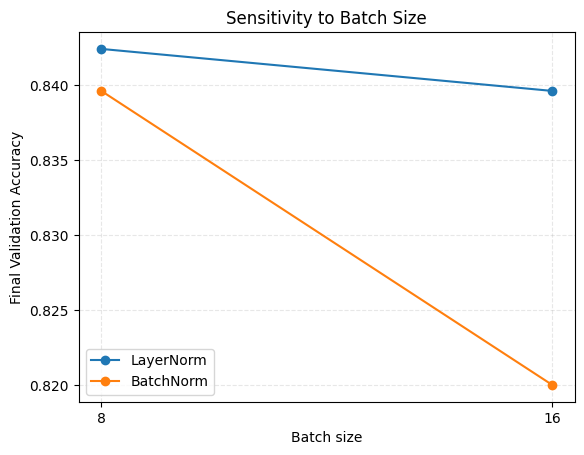

In [10]:
batch_sizes = [8, 16]  # extend to 128 if memory allows
results = {}
for bs in batch_sizes:
    print("Running LN bs=", bs)
    hist_ln, test_acc_ln = train_and_evaluate(norm_type="layernorm", model_size="small",
                                              batch_size=bs, lr=1e-4, num_epochs=CONFIG["num_epochs"],
                                              seed=CONFIG["seed"])
    print("Running BN bs=", bs)
    hist_bn, test_acc_bn = train_and_evaluate(norm_type="batchnorm", model_size="small",
                                              batch_size=bs, lr=1e-4, num_epochs=CONFIG["num_epochs"],
                                              seed=CONFIG["seed"])
    results[bs] = {"layernorm": hist_ln["val_acc"][-1], "batchnorm": hist_bn["val_acc"][-1]}
# plot
plot_sensitivity_batch_size(results)

Running LN bs= 32


Train epoch 1/6:   0%|          | 0/704 [00:00<?, ?it/s]

Epoch 1: train_loss=0.5917, train_acc=0.6767, val_loss=0.4918, val_acc=0.7576


Train epoch 2/6:   0%|          | 0/704 [00:00<?, ?it/s]

Epoch 2: train_loss=0.4695, train_acc=0.7763, val_loss=0.4435, val_acc=0.7912


Train epoch 3/6:   0%|          | 0/704 [00:00<?, ?it/s]

Epoch 3: train_loss=0.4187, train_acc=0.8069, val_loss=0.4595, val_acc=0.7912


Train epoch 4/6:   0%|          | 0/704 [00:00<?, ?it/s]

Epoch 4: train_loss=0.3753, train_acc=0.8316, val_loss=0.3983, val_acc=0.8296


Train epoch 5/6:   0%|          | 0/704 [00:00<?, ?it/s]

Epoch 5: train_loss=0.3461, train_acc=0.8484, val_loss=0.3951, val_acc=0.8300


Train epoch 6/6:   0%|          | 0/704 [00:00<?, ?it/s]

Epoch 6: train_loss=0.3134, train_acc=0.8651, val_loss=0.3793, val_acc=0.8380
Test accuracy: 0.82048
Running BN bs= 32


Train epoch 1/6:   0%|          | 0/704 [00:00<?, ?it/s]

Epoch 1: train_loss=0.5619, train_acc=0.7072, val_loss=0.4951, val_acc=0.7628


Train epoch 2/6:   0%|          | 0/704 [00:00<?, ?it/s]

Epoch 2: train_loss=0.4565, train_acc=0.7814, val_loss=0.4210, val_acc=0.8032


Train epoch 3/6:   0%|          | 0/704 [00:00<?, ?it/s]

Epoch 3: train_loss=0.3961, train_acc=0.8195, val_loss=0.3864, val_acc=0.8236


Train epoch 4/6:   0%|          | 0/704 [00:00<?, ?it/s]

Epoch 4: train_loss=0.3477, train_acc=0.8437, val_loss=0.4223, val_acc=0.8128


Train epoch 5/6:   0%|          | 0/704 [00:00<?, ?it/s]

Epoch 5: train_loss=0.3001, train_acc=0.8720, val_loss=0.4767, val_acc=0.7864


Train epoch 6/6:   0%|          | 0/704 [00:00<?, ?it/s]

Epoch 6: train_loss=0.2542, train_acc=0.8922, val_loss=0.5187, val_acc=0.7800
Test accuracy: 0.77836
Running LN bs= 64


Train epoch 1/6:   0%|          | 0/352 [00:00<?, ?it/s]

Epoch 1: train_loss=0.6213, train_acc=0.6404, val_loss=0.5153, val_acc=0.7464


Train epoch 2/6:   0%|          | 0/352 [00:00<?, ?it/s]

Epoch 2: train_loss=0.4963, train_acc=0.7588, val_loss=0.4467, val_acc=0.7888


Train epoch 3/6:   0%|          | 0/352 [00:00<?, ?it/s]

Epoch 3: train_loss=0.4418, train_acc=0.7908, val_loss=0.4236, val_acc=0.8036


Train epoch 4/6:   0%|          | 0/352 [00:00<?, ?it/s]

Epoch 4: train_loss=0.4033, train_acc=0.8173, val_loss=0.4077, val_acc=0.8116


Train epoch 5/6:   0%|          | 0/352 [00:00<?, ?it/s]

Epoch 5: train_loss=0.3752, train_acc=0.8334, val_loss=0.4001, val_acc=0.8224


Train epoch 6/6:   0%|          | 0/352 [00:00<?, ?it/s]

Epoch 6: train_loss=0.3493, train_acc=0.8452, val_loss=0.4007, val_acc=0.8212
Test accuracy: 0.80748
Running BN bs= 64


Train epoch 1/6:   0%|          | 0/352 [00:00<?, ?it/s]

Epoch 1: train_loss=0.5708, train_acc=0.7006, val_loss=0.8795, val_acc=0.5736


Train epoch 2/6:   0%|          | 0/352 [00:00<?, ?it/s]

Epoch 2: train_loss=0.4772, train_acc=0.7693, val_loss=0.4401, val_acc=0.7976


Train epoch 3/6:   0%|          | 0/352 [00:00<?, ?it/s]

Epoch 3: train_loss=0.4110, train_acc=0.8124, val_loss=0.4231, val_acc=0.8000


Train epoch 4/6:   0%|          | 0/352 [00:00<?, ?it/s]

Epoch 4: train_loss=0.3652, train_acc=0.8376, val_loss=0.4755, val_acc=0.7736


Train epoch 5/6:   0%|          | 0/352 [00:00<?, ?it/s]

Epoch 5: train_loss=0.3193, train_acc=0.8627, val_loss=0.4926, val_acc=0.7724


Train epoch 6/6:   0%|          | 0/352 [00:00<?, ?it/s]

Epoch 6: train_loss=0.2744, train_acc=0.8813, val_loss=0.4296, val_acc=0.8152
Test accuracy: 0.81016


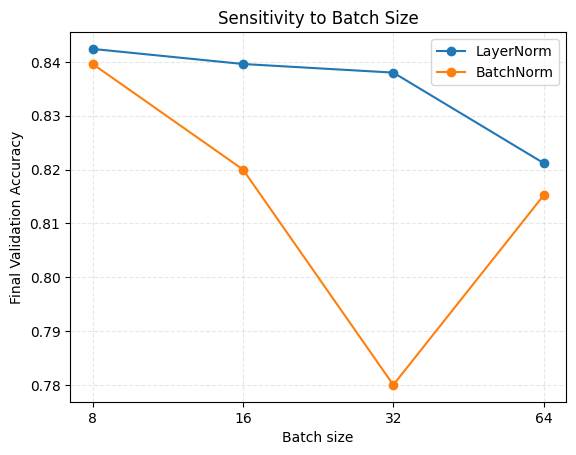

In [11]:
batch_sizes = [32, 64]  # extend to 128 if memory allows
for bs in batch_sizes:
    print("Running LN bs=", bs)
    hist_ln, test_acc_ln = train_and_evaluate(norm_type="layernorm", model_size="small",
                                              batch_size=bs, lr=1e-4, num_epochs=CONFIG["num_epochs"],
                                              seed=CONFIG["seed"])
    print("Running BN bs=", bs)
    hist_bn, test_acc_bn = train_and_evaluate(norm_type="batchnorm", model_size="small",
                                              batch_size=bs, lr=1e-4, num_epochs=CONFIG["num_epochs"],
                                              seed=CONFIG["seed"])
    results[bs] = {"layernorm": hist_ln["val_acc"][-1], "batchnorm": hist_bn["val_acc"][-1]}
# plot
plot_sensitivity_batch_size(results)

Running LN bs= 128


Train epoch 1/6:   0%|          | 0/176 [00:00<?, ?it/s]

Epoch 1: train_loss=0.6447, train_acc=0.6176, val_loss=0.5589, val_acc=0.7012


Train epoch 2/6:   0%|          | 0/176 [00:00<?, ?it/s]

Epoch 2: train_loss=0.5364, train_acc=0.7294, val_loss=0.4849, val_acc=0.7652


Train epoch 3/6:   0%|          | 0/176 [00:00<?, ?it/s]

Epoch 3: train_loss=0.4758, train_acc=0.7706, val_loss=0.4462, val_acc=0.7916


Train epoch 4/6:   0%|          | 0/176 [00:00<?, ?it/s]

Epoch 4: train_loss=0.4429, train_acc=0.7918, val_loss=0.4413, val_acc=0.7960


Train epoch 5/6:   0%|          | 0/176 [00:00<?, ?it/s]

Epoch 5: train_loss=0.4128, train_acc=0.8104, val_loss=0.4236, val_acc=0.8080


Train epoch 6/6:   0%|          | 0/176 [00:00<?, ?it/s]

Epoch 6: train_loss=0.3922, train_acc=0.8222, val_loss=0.4059, val_acc=0.8164
Test accuracy: 0.80004
Running BN bs= 128


Train epoch 1/6:   0%|          | 0/176 [00:00<?, ?it/s]

Epoch 1: train_loss=0.5841, train_acc=0.6888, val_loss=0.5518, val_acc=0.7104


Train epoch 2/6:   0%|          | 0/176 [00:00<?, ?it/s]

Epoch 2: train_loss=0.4968, train_acc=0.7581, val_loss=0.5823, val_acc=0.6948


Train epoch 3/6:   0%|          | 0/176 [00:00<?, ?it/s]

Epoch 3: train_loss=0.4372, train_acc=0.7976, val_loss=0.4714, val_acc=0.7676


Train epoch 4/6:   0%|          | 0/176 [00:00<?, ?it/s]

Epoch 4: train_loss=0.3873, train_acc=0.8248, val_loss=0.6458, val_acc=0.6908


Train epoch 5/6:   0%|          | 0/176 [00:00<?, ?it/s]

Epoch 5: train_loss=0.3424, train_acc=0.8509, val_loss=0.4206, val_acc=0.8112


Train epoch 6/6:   0%|          | 0/176 [00:00<?, ?it/s]

Epoch 6: train_loss=0.3045, train_acc=0.8677, val_loss=0.3928, val_acc=0.8272
Test accuracy: 0.81808


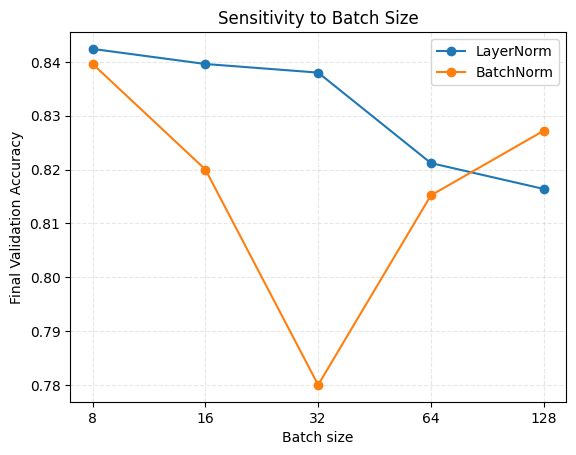

In [12]:
batch_sizes = [128]  # extend to 128 if memory allows
for bs in batch_sizes:
    print("Running LN bs=", bs)
    hist_ln, test_acc_ln = train_and_evaluate(norm_type="layernorm", model_size="small",
                                              batch_size=bs, lr=1e-4, num_epochs=CONFIG["num_epochs"],
                                              seed=CONFIG["seed"])
    print("Running BN bs=", bs)
    hist_bn, test_acc_bn = train_and_evaluate(norm_type="batchnorm", model_size="small",
                                              batch_size=bs, lr=1e-4, num_epochs=CONFIG["num_epochs"],
                                              seed=CONFIG["seed"])
    results[bs] = {"layernorm": hist_ln["val_acc"][-1], "batchnorm": hist_bn["val_acc"][-1]}
# plot
plot_sensitivity_batch_size(results)

Running LN bs= 256


Train epoch 1/6:   0%|          | 0/88 [00:00<?, ?it/s]

Epoch 1: train_loss=0.6598, train_acc=0.6062, val_loss=0.5976, val_acc=0.6656


Train epoch 2/6:   0%|          | 0/88 [00:00<?, ?it/s]

Epoch 2: train_loss=0.5658, train_acc=0.7065, val_loss=0.5181, val_acc=0.7380


Train epoch 3/6:   0%|          | 0/88 [00:00<?, ?it/s]

Epoch 3: train_loss=0.5136, train_acc=0.7480, val_loss=0.4848, val_acc=0.7616


Train epoch 4/6:   0%|          | 0/88 [00:00<?, ?it/s]

Epoch 4: train_loss=0.4871, train_acc=0.7619, val_loss=0.4551, val_acc=0.7872


Train epoch 5/6:   0%|          | 0/88 [00:00<?, ?it/s]

Epoch 5: train_loss=0.4539, train_acc=0.7868, val_loss=0.4431, val_acc=0.7948


Train epoch 6/6:   0%|          | 0/88 [00:00<?, ?it/s]

Epoch 6: train_loss=0.4323, train_acc=0.7996, val_loss=0.4284, val_acc=0.8012
Test accuracy: 0.7876
Running BN bs= 256


Train epoch 1/6:   0%|          | 0/88 [00:00<?, ?it/s]

Epoch 1: train_loss=0.6024, train_acc=0.6717, val_loss=0.6948, val_acc=0.6188


Train epoch 2/6:   0%|          | 0/88 [00:00<?, ?it/s]

Epoch 2: train_loss=0.5218, train_acc=0.7419, val_loss=0.4953, val_acc=0.7660


Train epoch 3/6:   0%|          | 0/88 [00:00<?, ?it/s]

Epoch 3: train_loss=0.4695, train_acc=0.7765, val_loss=0.5090, val_acc=0.7416


Train epoch 4/6:   0%|          | 0/88 [00:00<?, ?it/s]

Epoch 4: train_loss=0.4208, train_acc=0.8060, val_loss=0.5212, val_acc=0.7500


Train epoch 5/6:   0%|          | 0/88 [00:00<?, ?it/s]

Epoch 5: train_loss=0.3817, train_acc=0.8281, val_loss=1.2118, val_acc=0.5840


Train epoch 6/6:   0%|          | 0/88 [00:00<?, ?it/s]

Epoch 6: train_loss=0.3446, train_acc=0.8482, val_loss=0.4096, val_acc=0.8204
Test accuracy: 0.80968


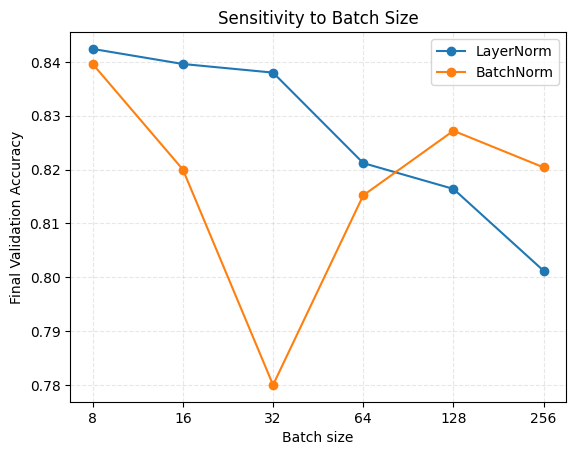

In [13]:
batch_sizes = [256]  # extend to 128 if memory allows
for bs in batch_sizes:
    print("Running LN bs=", bs)
    hist_ln, test_acc_ln = train_and_evaluate(norm_type="layernorm", model_size="small",
                                              batch_size=bs, lr=1e-4, num_epochs=CONFIG["num_epochs"],
                                              seed=CONFIG["seed"])
    print("Running BN bs=", bs)
    hist_bn, test_acc_bn = train_and_evaluate(norm_type="batchnorm", model_size="small",
                                              batch_size=bs, lr=1e-4, num_epochs=CONFIG["num_epochs"],
                                              seed=CONFIG["seed"])
    results[bs] = {"layernorm": hist_ln["val_acc"][-1], "batchnorm": hist_bn["val_acc"][-1]}
# plot
plot_sensitivity_batch_size(results)